# Experiment with Pytorch
to create endocder decoder ocr model with cnn and lstm

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Setup path in .env file
import os
from dotenv import load_dotenv
import cv2
import numpy as np
import torch

#torch.autograd.set_detect_anomal(True)

# Get absolut path to proeject root
load_dotenv()
project_root_dir = os.path.dirname(os.path.abspath("../"))
print("Project root dir:", project_root_dir)

data_dir = os.getenv("PUBTABNET_CROPPED_DATA_DIR")
absolute_dir = project_root_dir + "/" + data_dir
print("Absolute path:", absolute_dir)

Project root dir: /Users/simon/Documents/neural_networks_ocr_project
Absolute path: /Users/simon/Documents/neural_networks_ocr_project/neural_networks_seminar/data/PubTabNet_cropped


In [3]:
image_dir_train = f"{absolute_dir}/train"
image_dir_val = f"{absolute_dir}/val"
label_file_train = f"{absolute_dir}/PubTabNet_2.0.0_train_separated.json"
label_file_val = f"{absolute_dir}/PubTabNet_2.0.0_val_separated.json"

In [4]:
import sys
sys.path.append('../')
from torch.utils.data import DataLoader
label_file_small = f"{absolute_dir}/subset_small.json"


In [5]:
from torchvision import transforms
transform_list =  [transforms.Grayscale(1),
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,))]
transform = transforms.Compose(transform_list)

In [6]:
# Example usage:
from custom_ocr_cnn_lstm.dataset import OCRDataset
from custom_ocr_cnn_lstm.dataset_cropped import OCRDatasetCropped

train_dataset = OCRDatasetCropped(label_file_train, image_dir_train, transform=transform)
val_dataset = OCRDatasetCropped(label_file_val, image_dir_val, transform=transform)

# Accessing a sample
sample = train_dataset[0]
print(sample)

{'idx': 0, 'label': 'Species', 'image': tensor([[[ 1.0000,  0.9451,  0.5765,  0.7569,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  0.9294,  0.8902,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000],
         [ 1.0000,  0.0196,  0.9686,  0.5922,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  0.8824,  0.8353,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000],
         [ 1.0000, -0.2941,  0.8353,  1.0000,  0.8980,  0.5765,  0.3961,
           0.7412,  1.0000,  0.8039,  0.5529,  0.9608,  0.9294,  0.4745,
           0.6392,  0.7490,  0.7804,  1.0000,  0.7020,  0.6078,  1.0000,
           0.7020,  0.5608,  1.0000],
         [ 1.0000,  0.6235, -0.3804,  0.4588,  0.7804, -0.2000,  0.6157,
          -0.2706,  0.8980,  0.0118,  0.3490,  0.3725,  0.1765,  0.9765,
           0.6863,  0.4275,  0.4039,  0.560

In [7]:
max_height = 0
max_width = 0

for item in train_dataset:
    image = item['image']
    height, width = image.shape[1], image.shape[2]
    max_height = max(max_height, height)
    max_width = max(max_width, width)

# max_height = 143
# max_width = 467
print(f"Maximum Height: {max_height}")
print(f"Maximum Width: {max_width}")


Maximum Height: 143
Maximum Width: 467


In [8]:
import torch
import torch.nn.functional as F

class CustomCollator(object):
    
    def __init__(self, target_height = max_height, target_width= max_width):
        self.target_height = target_height
        self.target_width = target_width
    
    def __call__(self, batch):
        indexes = [item['idx'] for item in batch]
        
        # Resize images to the target size
        resized_images = []
        for item in batch:
            image = item['image']
            resized_image = F.interpolate(image.unsqueeze(0), size=(self.target_height, self.target_width), mode='bilinear', align_corners=False)
            resized_images.append(resized_image.squeeze(0))
        
        # Stack resized images
        imgs = torch.stack(resized_images, dim=0)
        
        item = {'image': imgs, 'idx': indexes}
        
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        
        return item


In [9]:
# Example usage:
from custom_ocr_cnn_lstm.dataset import OCRDataset
from custom_ocr_cnn_lstm.dataset_cropped import OCRDatasetCropped
from torch.utils.data import Subset

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=CustomCollator())
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True, collate_fn=CustomCollator())

------
torch.Size([10, 1, 143, 467])
0 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]) bruce21


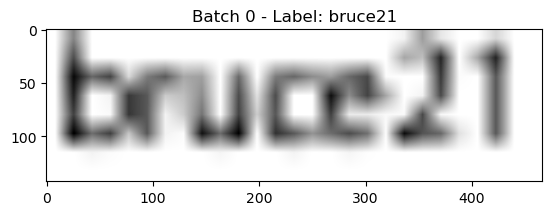

In [10]:
import matplotlib.pyplot as plt

# Vielleicht liegt der Fehler hier. 
# Batch enthält jeweils 3 items die dann 10 elemente jeweils enthalten
for batch_idx, samples in enumerate(train_loader):
    print("------")
    print(samples["image"].shape)
    print(batch_idx, samples["image"][0], samples["label"][0])

    # Access the grayscale image
    image = samples["image"][0][0]  # Assuming [batch, channel, height, width]

    # Visualize the image
    plt.imshow(image, cmap='gray')
    plt.title(f'Batch {batch_idx} - Label: {samples["label"][0]}')
    plt.show()
    break

In [11]:
import re
def remove_xml_tags(input_string):
    pattern = r'<[^>]+>'
    return re.sub(pattern, '', input_string)

In [12]:
import json
def create_alphabet_file(alphabet, file_path):
    with open(file_path, 'w') as f:
        # f.write("START\n")
        for char in alphabet:
            f.write(char + "\n")
        # f.write("END\n")

# Replace these with your actual ground truth labels
train_labels = train_dataset.labels
val_labels = train_dataset.labels
# Concat both dicts
labels = train_labels + val_labels

alph_labels = []
for label in labels:
    label_tokens = label.get('tokens')
    label = " ".join(" ".join(tokens) for tokens in label_tokens)
    label = remove_xml_tags(label)
    alph_labels.append(label)
print("Ground truth labels loaded: ", len(alph_labels), alph_labels[:100])

unique_chars = set()
unique_radicals = set()

# Loop through ground truth labels to extract unique characters and radicals
for label in alph_labels:
    for char in label:
        unique_chars.add(char)
        # You might need to extract radicals from each character here if using decomposition

# Define the file paths for character and radical alphabets
char_alphabet_file_path = f"{absolute_dir}/character_alphabet.txt"
radical_alphabet_file_path = f"{absolute_dir}/radical_alphabet.txt"

# Create character alphabet file
create_alphabet_file(unique_chars, char_alphabet_file_path)
print(f"Character alphabet file created at: {char_alphabet_file_path}")

# Create radical alphabet file (if needed)
# create_alphabet_file(unique_radicals, radical_alphabet_file_path)
# print(f"Radical alphabet file created at: {radical_alphabet_file_path}")

Ground truth labels loaded:  133670 [' S p e c i e s ', ' A n a j a ́ s ', ' P o r t e l ', ' S S B V ', ' W i l d ', ' R u r a l ', ' U r b a n ', ' W i l d ', ' R u r a l ', ' U r b a n ', ' W i l d ', ' R u r a l ', ' U r b a n ', ' T o t a l ', ' ( % ) ', ' E v a n d r o m y i a   w a l k e r i ', '4 4', '4 0', '1', '1 5 6', '2 9 6', '1', '5 1', '1', '2', '5 9 2', '6 8 . 8 4', ' E v a n d r o m y i a   i n f r a s p i n o s a ', '4 4', '0', '3', '8 2', '1', '0', '0', '0', '0', '1 3 0', '1 5 . 1 2', ' N y s s o m y i a   a n t u n e s i  a  ', '1 1', '3', '3', '2 0', '3', '0', '1', '0', '0', '4 1', '4 . 7 7', ' M i c r o p y g o m y i a   r o r o t a e n s i s ', '2 0', '1', '0', '4', '0', '0', '2', '0', '0', '2 7', '3 . 1 4', ' S c i o p e m y i a   s o r d e l l i i ', '7', '1', '0', '1 3', '2', '0', '2', '0', '0', '2 5', '2 . 9 1', ' B i c h r o m o m y i a   f l a v i s c u t e l l a t a  a  ', '0', '0', '0', '4', '0', '0', '1 6', '0', '0', '2 0', '2 . 3 2', ' N y s s o m y i a 

https://deepayan137.github.io/blog/markdown/2020/08/29/building-ocr.html#the-ctc-loss

In [13]:
# From https://deepayan137.github.io/blog/markdown/2020/08/29/building-ocr.html#the-ctc-loss
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

In [14]:
# Load alpabet from file
def load_alphabet(file_path):
    with open(file_path, 'r') as f:
        alphabet = f.read().splitlines()
    return alphabet

alphabet = load_alphabet(char_alphabet_file_path)
print("Alphabet loaded:", len(alphabet), alphabet)

Alphabet loaded: 164 ['–', 'W', 'Q', '£', '∑', '.', ',', '”', '/', '‐', 'Z', 'n', 'F', 'Δ', 'M', 'α', '5', '|', '↓', ':', 'E', '∞', '×', 'T', 'X', '`', 'θ', '%', 'r', '<', 'κ', 'σ', '±', 'v', 't', '&', 'x', 'D', '→', '>', '¶', '8', '*', 'Ø', 'λ', 'Y', 'τ', ';', 'z', '≥', 'g', 'μ', '"', '“', '·', '−', 'l', ' ', '®', 'ν', '’', '~', 'J', '?', 'O', 'A', 'e', 'ψ', 'd', '†', '‡', 'B', 'y', 'L', '^', 'R', 's', 'f', '̀', '̊', '∩', 'c', 'P', "'", '€', '[', '_', 'S', '∗', '-', '{', '1', '′', '2', '°', '#', 'χ', '3', 'u', 'p', 'ε', '⁄', 'm', 'C', 'w', 'ß', 'U', '≦', '̂', '©', '▪', 'a', '—', 'ω', ')', 'η', '•', '4', '9', 'i', 'Χ', '‘', '̄', '̧', 'K', 'V', '7', 'o', '⩽', '∼', '̃', 'N', 'G', '=', '́', '+', '̈', 'q', '0', 'γ', '∙', 'I', 'φ', 'k', '}', 'β', '↑', '✓', '\u200b', ']', '$', '◦', 'δ', 'Σ', '§', '≤', 'b', 'j', 'H', '¥', 'ρ', '6', 'h', '(']


In [15]:
def find_maximum_width(dataset):
    # Initialize a list to store image widths
    image_widths = []

    # Iterate through the dataset and collect image widths
    for sample in dataset:
        image_width = sample['image'].shape[2]  # Get the width of the image
        image_widths.append(image_width)

    # Find the maximum width across all images
    max_width = max(image_widths)

    return max_width

# Example usage:
max_width_train = find_maximum_width(train_dataset)
max_width_val = find_maximum_width(val_dataset)

max_width = max(max_width_train, max_width_val)
#max_width = 491

print("Maximum width in dataset:", max_width)


Maximum width in dataset: 491


In [18]:
# Setup environment for training
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
from utils import OCRLabelConverter
from tqdm import *
from cnn_lstm_ocr import CNNLSTM_OCR


params = {
    "input_dim": 1,  # Assuming grayscale images
    "alphabet": alphabet,
    "hidden_dim": 256,
    "output_dim": len(alphabet) + 1,  # Number of classes (including a blank symbol)
    "input_planes": 1,  # Assuming grayscale images
    "planes": 32,  # Adjust this value as needed
    'image_height': 32,  # Adjust as needed
    'number_channels': 1,  # Assuming grayscale images
    'number_hidden_layers': 2,  # Adjust as needed
    'len_alphabet': len(alphabet),  # Number of classes (excluding a blank symbol)
    'learning_rate': 0.00001,
    'epochs': 1,
    'batch_size': 10,
    'model_dir': '/Users/simon/Documents/neural_networks_ocr_project/neural_networks_seminar/custom_ocr_cnn_lstm',
    'log_dir': 'logs',
    'resume': False,
    'cuda': False,
    'schedule': False,
    'max_width': max_width
}


model = CNNLSTM_OCR(params)
converter = OCRLabelConverter(''.join(params['alphabet']))
criterion = CustomCTCLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
scheduler = CosineAnnealingLR(optimizer, T_max=params['epochs'])
batch_size = params['batch_size']
count = 1
epochs = params['epochs']
cuda = params['cuda']
print("Params:", params)

def train_dataloader():
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader

Params: {'input_dim': 32, 'alphabet': ['–', 'W', 'Q', '£', '∑', '.', ',', '”', '/', '‐', 'Z', 'n', 'F', 'Δ', 'M', 'α', '5', '|', '↓', ':', 'E', '∞', '×', 'T', 'X', '`', 'θ', '%', 'r', '<', 'κ', 'σ', '±', 'v', 't', '&', 'x', 'D', '→', '>', '¶', '8', '*', 'Ø', 'λ', 'Y', 'τ', ';', 'z', '≥', 'g', 'μ', '"', '“', '·', '−', 'l', ' ', '®', 'ν', '’', '~', 'J', '?', 'O', 'A', 'e', 'ψ', 'd', '†', '‡', 'B', 'y', 'L', '^', 'R', 's', 'f', '̀', '̊', '∩', 'c', 'P', "'", '€', '[', '_', 'S', '∗', '-', '{', '1', '′', '2', '°', '#', 'χ', '3', 'u', 'p', 'ε', '⁄', 'm', 'C', 'w', 'ß', 'U', '≦', '̂', '©', '▪', 'a', '—', 'ω', ')', 'η', '•', '4', '9', 'i', 'Χ', '‘', '̄', '̧', 'K', 'V', '7', 'o', '⩽', '∼', '̃', 'N', 'G', '=', '́', '+', '̈', 'q', '0', 'γ', '∙', 'I', 'φ', 'k', '}', 'β', '↑', '✓', '\u200b', ']', '$', '◦', 'δ', 'Σ', '§', '≤', 'b', 'j', 'H', '¥', 'ρ', '6', 'h', '('], 'hidden_dim': 256, 'output_dim': 165, 'input_planes': 1, 'planes': 32, 'image_height': 32, 'number_channels': 1, 'number_hidden_layers'

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from custom_ocr_cnn_lstm.cnn_lstm_ocr import CNNLSTM_OCR
import math

# Define your model, criterion, optimizer, and other parameters here

# Initialize your model, criterion, and optimizer
model = CNNLSTM_OCR(params)  # Assuming you've already defined CNNLSTM_OCR class
# criterion = nn.CTCLoss()
criterion = CustomCTCLoss()
optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
scheduler = CosineAnnealingLR(optimizer, T_max=params['epochs'])

# Define training loop
def train(model, dataloader, criterion, optimizer, device, clip_grad_max_norm):
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader, desc="Training"):
        inputs = batch['image'].to(device)
        targets = batch['label']

        targets_encoded = []
        targets_encoded_length = []
        for target in targets: 
            target, length = converter.encode(target)
            targets_encoded.append(target)
            targets_encoded_length.append(len(length))
        
        # Find the length of the longest tensor
        max_len = max(len(t) for t in targets_encoded)

        # Pad tensors to the length of the longest tensor
        padded_tensors = [F.pad(t, (0, max_len - len(t)), value=112) for t in targets_encoded]

        # Stack the padded tensors
        targets_encoded = torch.stack(padded_tensors)

        # target lengths as tensor
        targets_encoded_length = torch.IntTensor(targets_encoded_length)

        optimizer.zero_grad()
        # print("cnn input inputs.shape:", inputs.shape)
        outputs = model(inputs)
        outputs = outputs.contiguous().cpu()
        outputs = torch.nn.functional.log_softmax(outputs, 2)
        # b is batch size, T is input sequence and h is hidden size
        b, T, h = outputs.size()

        pred_sizes = torch.LongTensor([T for i in range(b)])
        _, pos = outputs.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)

        # sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        # for word_pred, word_target in zip(sim_preds, targets):
        #     print(f"Prediction word length: {len(word_pred)}, Target word length: {len(word_target)}")

        pred_sizes = torch.LongTensor([T for i in range(b)])
        
        loss = criterion(outputs.transpose(0, 1), targets_encoded, pred_sizes, targets_encoded_length)

        # Calculate gradients
        loss.backward()

        # Apply gradient clipping
        if clip_grad_max_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad_max_norm)

        # Update weights
        optimizer.step()
        
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Define validation method
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            inputs = batch['image'].to(device)
            targets = batch['label']
            
            targets_encoded = []
            targets_encoded_length = []
            for target in targets: 
                target, length = converter.encode(target)
                targets_encoded.append(target)
                targets_encoded_length.append(len(length))
            
            # Find the length of the longest tensor
            max_len = max(len(t) for t in targets_encoded)

            # Pad tensors to the length of the longest tensor
            padded_tensors = [F.pad(t, (0, max_len - len(t)), value=112) for t in targets_encoded]

            # Stack the padded tensors
            targets_encoded = torch.stack(padded_tensors)

            # target lengths as tensor
            targets_encoded_length = torch.IntTensor(targets_encoded_length)

            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.contiguous().cpu()
            outputs = torch.nn.functional.log_softmax(outputs, 2)

            # b is batch size, T is input sequence and h is hidden size
            b, T, h = outputs.size()
            pred_sizes = torch.LongTensor([T for i in range(b)])
            
            loss = criterion(outputs.transpose(0, 1), targets_encoded, pred_sizes, targets_encoded_length)

            total_loss += loss.item()

    return total_loss / len(dataloader)

# Training loop
device = torch.device("cuda" if params['cuda'] and torch.cuda.is_available() else "cpu")
model.to(device)
train_dataloader = train_loader  # Assuming you have train_loader defined
val_dataloader = val_loader  # Assuming you have val_loader defined
clip_grad_max_norm = 1.0  # Set your desired maximum gradient norm

for epoch in range(params['epochs']):
    print(f"Epoch {epoch+1}/{params['epochs']}")
    train_loss = train(model, train_dataloader, criterion, optimizer, device, clip_grad_max_norm)
    val_loss = validate(model, val_dataloader, criterion, device)
    scheduler.step()  # Adjust learning rate
    
    print(f"Epoch {epoch+1}/{params['epochs']} - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")
    #print(f"Epoch {epoch+1}/{params['epochs']} - Train Loss: {train_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), params['model_dir'] + '/model.pth')


Epoch 1/1


Validation: 100%|██████████| 6771/6771 [1:14:01<00:00,  1.52it/s]

Epoch 1/1 - Train Loss: 285.6998 - Validation Loss: 4.0279


In [20]:
resume_file = "/Users/simon/Documents/neural_networks_ocr_project/neural_networks_seminar/custom_ocr_cnn_lstm/model.pth"

checkpoint = torch.load(resume_file)
print(checkpoint.keys())
model.load_state_dict(checkpoint)

odict_keys(['cnn_encoder.conv_layer_1.weight', 'cnn_encoder.bn1.weight', 'cnn_encoder.bn1.bias', 'cnn_encoder.bn1.running_mean', 'cnn_encoder.bn1.running_var', 'cnn_encoder.bn1.num_batches_tracked', 'cnn_encoder.conv_layer_2.weight', 'cnn_encoder.bn2.weight', 'cnn_encoder.bn2.bias', 'cnn_encoder.bn2.running_mean', 'cnn_encoder.bn2.running_var', 'cnn_encoder.bn2.num_batches_tracked', 'lstm_decoder.lstm.weight_ih_l0', 'lstm_decoder.lstm.weight_hh_l0', 'lstm_decoder.lstm.bias_ih_l0', 'lstm_decoder.lstm.bias_hh_l0', 'lstm_decoder.lstm.weight_ih_l0_reverse', 'lstm_decoder.lstm.weight_hh_l0_reverse', 'lstm_decoder.lstm.bias_ih_l0_reverse', 'lstm_decoder.lstm.bias_hh_l0_reverse', 'lstm_decoder.embedding.weight', 'lstm_decoder.embedding.bias'])


<All keys matched successfully>

In [21]:
val_dataloader = val_loader  

for batch in tqdm(val_dataloader, desc="Validation"):
    inputs = batch['image'].to(device)
    targets = batch['label']
    print(targets)
    print(f"Length of targets: {len(targets)}")

    outputs = model(inputs)
    outputs = outputs.contiguous().cpu()
    outputs = torch.nn.functional.log_softmax(outputs, 2)

    B, T, H = outputs.size()
    pred_sizes = torch.LongTensor([T for i in range(B)])
    probs, pos = outputs.max(2)
    pos = pos.transpose(1, 0).contiguous().view(-1)

    sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
    print(sim_preds)
    print(f"Length of sim_preds: {len(sim_preds)}")
    break

Validation:   0%|          | 0/6771 [00:00<?, ?it/s]

['0', '8', 'Fats and oils', '85', 'Pepsinogen I (μg/mL)', 'Rb1', 'Asian/Pacific Islander', 'Herbarium', '207.0', ' Medium activity']
Length of targets: 10


Validation:   0%|          | 0/6771 [00:00<?, ?it/s]

['', '', '', '', '', '', '', '', '', '']
Length of sim_preds: 10
